In [1]:
import numpy as np
import dedalus.public as d3
import matplotlib.pyplot as plt

In [5]:
unstable = 0.23752649 + 1j*0.00373967

# Parameters
N = 512
alpha = 1.0
R = 10000.0

# Basis
coord = d3.Coordinate('y')
dist = d3.Distributor(coord, dtype=np.complex128)
basis  = d3.Chebyshev(coord, N, bounds=(-1, 1))

# Fields
u = dist.Field(name='u', bases=basis)
v = dist.Field(name='v', bases=basis)
p = dist.Field(name='p', bases=basis)
c = dist.Field(name='c')

tau_u1 = dist.Field(name='tau_u1'); tau_u2 = dist.Field(name='tau_u2')
tau_v1 = dist.Field(name='tau_v1'); tau_v2 = dist.Field(name='tau_v2')

U = dist.Field(name='U', bases=basis)
Uy = dist.Field(name='Uy', bases=basis)

# substitutions
dy = lambda A: d3.Differentiate(A, coord)
lift_basis = basis.derivative_basis(1)
lift = lambda A: d3.lift(A, lift_basis, -1)
uy = dy(u) + lift(tau_u1); uyy = dy(uy) + lift(tau_u2)
vy = dy(v) + lift(tau_v1); vyy = dy(vy) + lift(tau_v2)
py = dy(p)

# setup the base flow and parameters
y = dist.local_grid(basis)
U['g'] = 1 - y**2
Uy['g'] = -2*y

# problem
problem = d3.EVP([u, v, p, tau_u1, tau_u2, tau_v1, tau_v2], eigenvalue=c, namespace=locals())
problem.add_equation("1j*alpha*u + vy = 0")
problem.add_equation("1j*alpha*U*u + v*Uy + 1/R*(alpha**2*u - uyy) + 1j*alpha*p - 1j*c*alpha*u = 0")
problem.add_equation("1j*alpha*U*v + 1/R*(alpha**2*v - vyy) + py - 1j*c*alpha*v = 0")
problem.add_equation("u(y = -1) = 0")
problem.add_equation("u(y =  1) = 0")
problem.add_equation("v(y = -1) = 0")
problem.add_equation("v(y =  1) = 0")

solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])

2025-04-19 20:23:59,315 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


In [14]:
iloc = np.argmin(np.abs(solver.eigenvalues - unstable))
solver.set_state(np.argmin(np.abs(solver.eigenvalues - unstable)))
print(solver.eigenvalues[iloc])

(0.23752648882051397+0.0037396706229695154j)


In [15]:
x = np.linspace(0, 4*np.pi, 512, endpoint=False)
xgrid, ygrid = np.meshgrid(x, y, indexing='ij')
nm = np.exp(1j*alpha*xgrid)
u2d = u['g'][np.newaxis, :]*nm
v2d = v['g'][np.newaxis, :]*nm

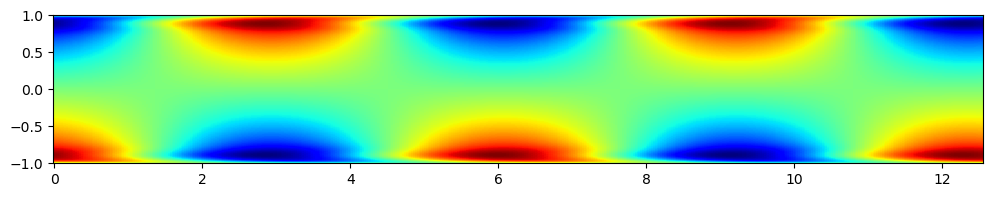

In [21]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect('equal')
ax.pcolormesh(xgrid, ygrid, u2d.real, cmap='jet')

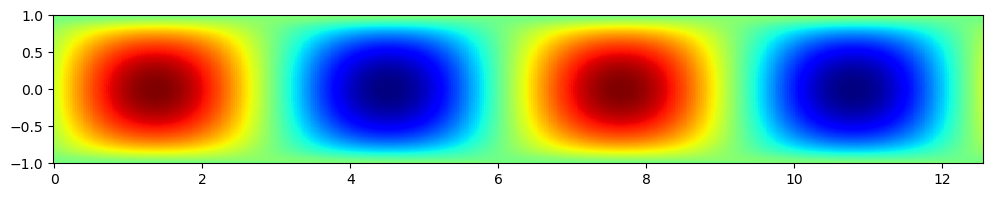

In [22]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect('equal')
ax.pcolormesh(xgrid, ygrid, v2d.real, cmap='jet')

In [25]:
u2d.real.max()

np.float64(0.852085853526646)